In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

<H1 style="background-color:LightGreen;">
    <center>
         Links
     </center>
 </H1>

https://medium.com/analytics-vidhya/style-transfer-pytorch-84cf2e9ba86d

<H1 style="background-color:LightGreen;">
    <center>
         Bried
     </center>
 </H1>

<ol>
  <li> Style transfer uses a pre-trained CNN to find the content features of an image and the style features of another image to mix them</li>
  <li> Content features of an image — objects </li>
  <li> style features of an image   — brush, texture, colour  </li>
  <li> The content image is passed through the VGG-19 network where the content representation is extracted. </li>
  <li> The style image is passed through the VGG-19 network where the style representation is extracted and stored using a gram matrix. </li>
    <li> The later layers of the VGG-19 CNN capture the content of the image better  </li>
    <li> The content representation identifies lines and intensities to outline the objects of an image </li>
    <li> Notice that the content representation discards all irrelevant details including the style to preserve the primary objects in an image. </li>
    <li> Style is how each aspect of a painting relates with each other </li>
    <li> To find the style, we begin by inputting the style image through the VGG-19 CNN to observe the correlations between feature maps in convolutional layers </li>


</ol>

<H1 style="background-color:LightGreen;">
    <center>
         Code
     </center>
 </H1>

In [3]:
import torch
import torchinfo

import pandas                 as pd
import numpy                  as np
import matplotlib.pyplot      as plt
import torchvision.transforms as transforms
import torchvision.models     as models
import pylab                  as pl

from IPython                  import display
from PIL                      import Image
from tqdm                     import tqdm 



<H1 style="background-color:LightGreen;">
    <center>
         Get VGG19 and freeze parameters
     </center>
 </H1>

In [4]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

<H1 style="background-color:LightGreen;">
    <center>
         Load Image, Reshape (400), Normalize (VGG19 Wights) and return tensor
     </center>
 </H1>

In [6]:
def load_image(img_path, max_size=400, shape=None):
    
    # load
    image = Image.open(img_path).convert('RGB')    
    
    # resize (fit to memory)
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
            
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)    
    return image

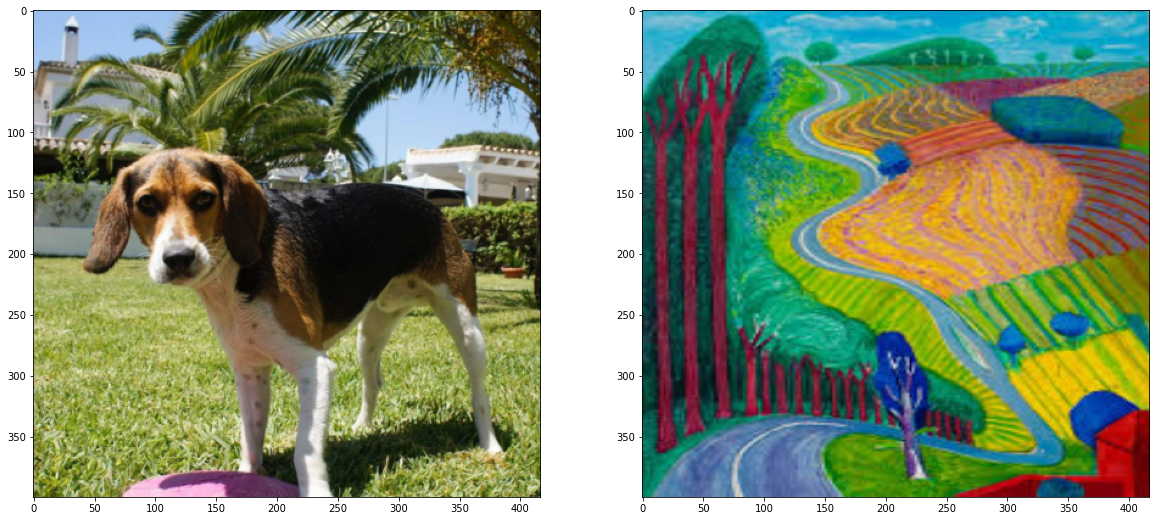

In [7]:
# load in content and style image

content = load_image('./roscon_1.jpg').to(device)
#content = load_image('./shira.jpg').to(device)
#style   = load_image('./hockney.jpg', shape=content.shape[-2:]).to(device)
style   = load_image('./hockney.jpg', shape=content.shape[-2:]).to(device)

# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)    
    return image

# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))



<H1 style="background-color:LightGreen;">
    <center>
         get image features
     </center>
 </H1>

In [8]:
def get_features(image, model, layers=None):
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x        = image
        
    for name, layer in model._modules.items():
        
        x = layer(x)
        if name in layers:            
            features[layers[name]] = x
            
    return features

In [9]:
def gram_matrix(tensor):
    """
        Calculate the Gram Matrix of a given tensor       
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [10]:
content_features = get_features(content, vgg)
style_features   = get_features(style,   vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
target      = content.clone().requires_grad_(True).to(device)  

In [11]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight   = 1e7  # beta

<H1 style="background-color:LightGreen;">
    <center>
         Plot each feature
     </center>
 </H1>

https://androidkt.com/how-to-visualize-feature-maps-in-convolutional-neural-networks-using-pytorch/

In [12]:

target_img      = content.clone().requires_grad_(False).to(device)  
target_features = get_features(target, vgg)        
target_features.keys()

content_layers = []
style_layers   = []
all_layers     = []

layers = {'0': 'conv1_1',
          '5': 'conv2_1', 
          '10': 'conv3_1', 
          '19': 'conv4_1',
          '21': 'conv4_2',  ## content representation
          '28': 'conv5_1'}


for layer_num, layer in vgg._modules.items():    
    if isinstance(layer, torch.nn.Conv2d):                        
        if layer_num in layers.keys():
            all_layers.append(layer)
            if layer_num == "21":                
                content_layers.append(layer)            
            else:
                style_layers.append(layer)




In [13]:


style_res   = []
content_res = []
all_res     = []
#for conv_layer in style_layers:    
for i, conv_layer in enumerate(all_layers):    
    res = conv_layer(target_img) 
    
    # 4 == content_res, see 'layers' above
    all_res.append(res.cpu().detach())
    if i == 4:
        content_res.append(res.cpu().detach())
    else:
        style_res.append(res.cpu().detach())
    print(f"\n(Style) input: {target_img.shape}, output: {res.shape}, {res.squeeze(0).shape}")
    target_img = res 



(Style) input: torch.Size([1, 3, 400, 417]), output: torch.Size([1, 64, 400, 417]), torch.Size([64, 400, 417])

(Style) input: torch.Size([1, 64, 400, 417]), output: torch.Size([1, 128, 400, 417]), torch.Size([128, 400, 417])

(Style) input: torch.Size([1, 128, 400, 417]), output: torch.Size([1, 256, 400, 417]), torch.Size([256, 400, 417])

(Style) input: torch.Size([1, 256, 400, 417]), output: torch.Size([1, 512, 400, 417]), torch.Size([512, 400, 417])

(Style) input: torch.Size([1, 512, 400, 417]), output: torch.Size([1, 512, 400, 417]), torch.Size([512, 400, 417])

(Style) input: torch.Size([1, 512, 400, 417]), output: torch.Size([1, 512, 400, 417]), torch.Size([512, 400, 417])


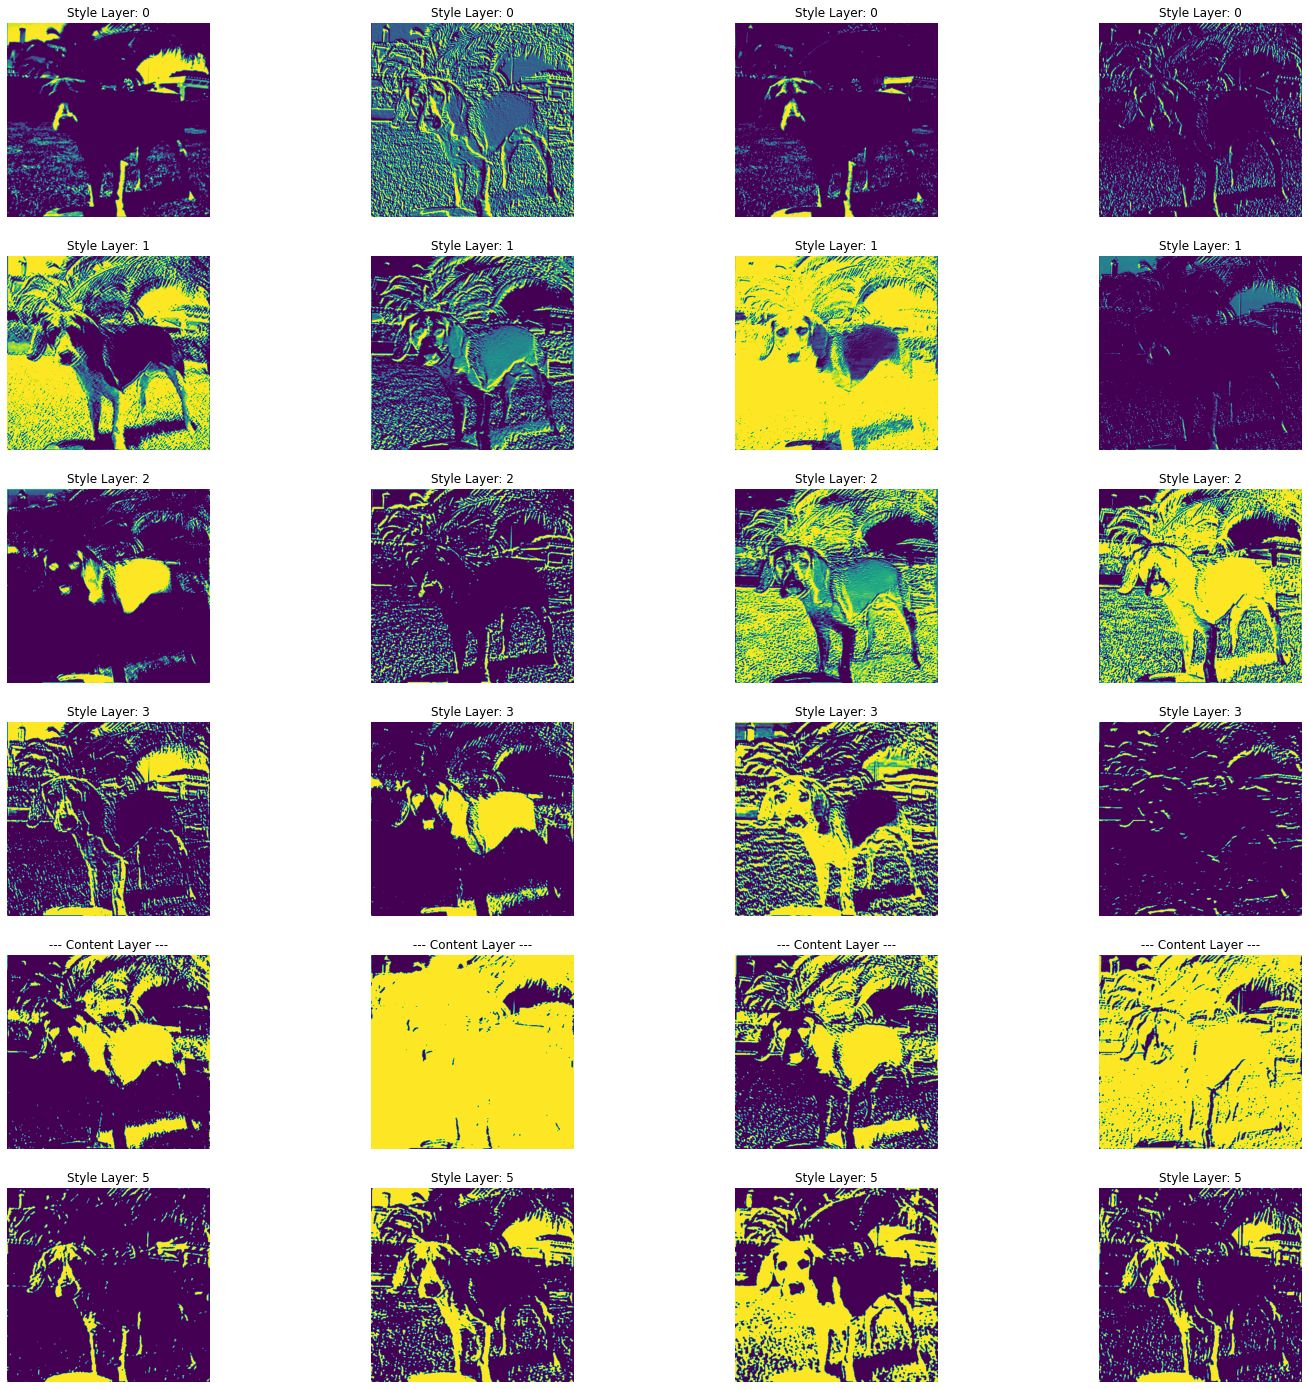

In [14]:
arr_imgs              = []
num_of_layers_to_show = 4

def plot_style_or_content(feature_layers):
    fig, axs              = plt.subplots(len(feature_layers), num_of_layers_to_show, figsize=(25, 25))

    for i in range(len(feature_layers)):

        layer_to_show = feature_layers[i]
        layer_to_show = layer_to_show.squeeze()
        layer_to_show = layer_to_show.clip(0,1)

        for j in range(num_of_layers_to_show):

            img = torch.unsqueeze(layer_to_show[j], 0)
            img = img.numpy()              
            img = img.transpose(1,2,0)
            x   = i
            y   = j 
            axs[x, y].imshow(img)
            if i == 4:
                title = f" --- Content Layer --- "
            else:
                title = f"Style Layer: {i}"
            axs[x, y].set_title(title)
            axs[x, y].axis('off')
            
            
plot_style_or_content(all_res)            


<H1 style="background-color:LightGreen;">
    <center>
         Run Model
     </center>
 </H1>

<Figure size 720x1440 with 0 Axes>

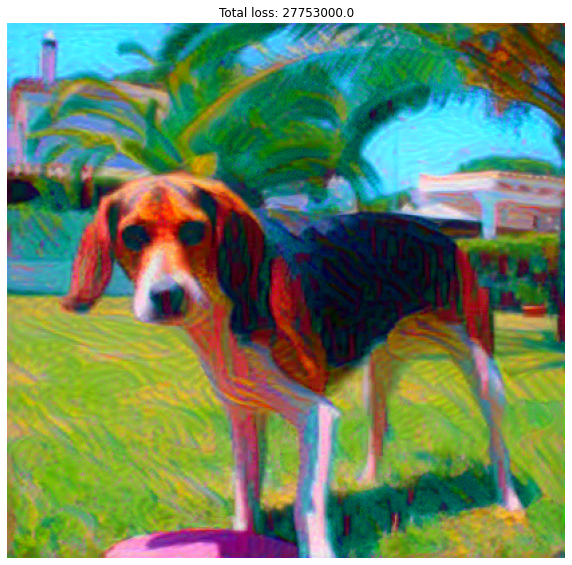

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2393/3000 [02:14<00:34, 17.79it/s]


KeyboardInterrupt: 

In [15]:
optimizer  = torch.optim.Adam([target], lr=0.002)
steps      = 3000
show_every = steps/20

plt.imshow(im_convert(content))
plt.rcParams["figure.figsize"] = (10,20)
plt.axis('off')
plt.show()
    

for ii in tqdm(range(1, steps+1)):
            
    target_features = get_features(target, vgg)        
    content_loss    = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_loss = 0

    for layer in style_weights:
        
        target_feature   = target_features[layer]
        target_gram      = gram_matrix(target_feature)
        _, d, h, w       = target_feature.shape        
        style_gram       = style_grams[layer]        
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)        
        style_loss      += layer_style_loss / (d * h * w)
            
    total_loss = content_weight * content_loss + style_weight * style_loss
        
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    
    if  ii % show_every == 0:
        title = f"Total loss: {total_loss.item()}"        
        display.clear_output(wait=False)
        display.display(pl.gcf())
        plt.imshow(im_convert(target))
        plt.rcParams["figure.figsize"] = (10,20)
        plt.title(title)
        plt.axis('off')
        plt.show()

    
  